# Exploring iTunes Movie Data #



## 1. Introducing the data ##

The data comes from the iTunes store, where I've collected data from the [iTunes RSS feed](https://rss.itunes.apple.com/en-gb) and [iTunes Search API](https://developer.apple.com/library/archive/documentation/AudioVideo/Conceptual/iTuneSearchAPI/index.html). You can follow my data collection process through my [Github repository and README](https://github.com/zacharyang/movies-project). I've collected a total of 1,800 of the latest and most popular movies on iTunes across 9 different countries. These are mainly countries in the APAC market, ie. Australia, Indonesia, Malaysia, New Zealand, The Philippines, Singapore, Thailand and Vietnam. I've also included movies from the US iTunes store.

Ultimately, I'd like to be predicting the price that a movie would list at on iTunes. I'll start with the iTunes data, but I'll be moving on to other movie datasets to supplement my analysis. 





In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import requests as rq
import warnings
import matplotlib.dates as mdates
from datetime import datetime 
from scipy import stats

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
itunes_main=pd.read_json('../data/itunes_data.json',orient='records')

In [2]:
with open ('../data/itunes_data.json') as file:
    itunes_dat=json.load(file)
    file.close()

In [4]:
itunes_dat[1]

{'artistName': 'Christopher McQuarrie',
 'artworkUrl100': 'https://is3-ssl.mzstatic.com/image/thumb/Video128/v4/96/4b/c3/964bc350-2122-22d7-1a2c-975a2b8d4231/source/100x100bb.jpg',
 'artworkUrl30': 'https://is3-ssl.mzstatic.com/image/thumb/Video128/v4/96/4b/c3/964bc350-2122-22d7-1a2c-975a2b8d4231/source/30x30bb.jpg',
 'artworkUrl60': 'https://is3-ssl.mzstatic.com/image/thumb/Video128/v4/96/4b/c3/964bc350-2122-22d7-1a2c-975a2b8d4231/source/60x60bb.jpg',
 'collectionArtistId': 1008915738,
 'collectionArtistViewUrl': 'https://itunes.apple.com/us/artist/paramount-home-entertainment-inc/1008915738?uo=4',
 'collectionCensoredName': 'Mission: Impossible - The 6 Movie Collection',
 'collectionExplicitness': 'notExplicit',
 'collectionHdPrice': 19.99,
 'collectionId': 1441153541,
 'collectionName': 'Mission: Impossible - The 6 Movie Collection',
 'collectionPrice': 14.99,
 'collectionViewUrl': 'https://itunes.apple.com/us/movie/mission-impossible-fallout/id1406515547?uo=4',
 'contentAdvisoryRat

In [4]:
itunes_main.shape

(1800, 42)

In [5]:
itunes_main.dtypes

artistId                   float64
artistName                  object
artistViewUrl               object
artworkUrl100               object
artworkUrl30                object
artworkUrl60                object
collectionArtistId         float64
collectionArtistViewUrl     object
collectionCensoredName      object
collectionExplicitness      object
collectionHdPrice          float64
collectionId               float64
collectionName              object
collectionPrice            float64
collectionType              object
collectionViewUrl           object
contentAdvisoryRating       object
copyright                   object
country                     object
currency                    object
discCount                  float64
discNumber                 float64
hasITunesExtras            float64
kind                        object
longDescription             object
previewUrl                  object
primaryGenreName            object
releaseDate                 object
shortDescription    

## 1.1 Data Dictionary and Defintions ##

This is a description of the major data fields that I'll be focusing on in my analysis. There are other features within the data that I'll be excluding from the analysis but these can be viewed in the `itunes_main` dataframe. There's also more information in the [iTunes API documentation](https://developer.apple.com/library/archive/documentation/AudioVideo/Conceptual/iTuneSearchAPI/UnderstandingSearchResults.html#//apple_ref/doc/uid/TP40017632-CH8-SW1).

| Variable Name |  Type   |Description|
| :----------:  | :-----: |:------------:|
|     artistId   |  String | Unique artist identifier|
|     artistName      | String | Artist Name, usually refers to director or production studio|
|     country | String| 3-letter country ISO 3166 ALPHA-3 code  |
|     currency      | String | 3-letter currency ISO 4217 code |
|     longDescription   |  String | Synopsis of the movie as listed in the iTunes store|
|     primaryGenreName     | String| Genre of the movie|
|    releaseDate   | String | Date when movie was first released |
|     shortDescription    | String | Short synopsis of the movie as listed in the iTunes store |
|     trackId   |  Float| Unique Movie ID listed on the iTunes Store|
|     trackHdRentalPrice     | Float | Listed Unit Price of renting a movie in HD in local currency |
|     trackHdPrice   | Float | Listed Unit Price of buying a movie in HD in local currency |
|     trackPrice     | Float | Listed Unit Price of buying a movie in local currency |
|     trackRentalPrice   |  Float | Listed Unit Price of renting a movie in local currency|
|     trackTimeMillis      | Float | Run Time of movie in milliseconds|


## 2. Feature Selection and Sub-setting ##

I'll be selecting a few features here since I don't need all of them, particularly the "collection-" type features which are only meant for bundled movies, eg. those in sequels. 

I'll be focusing on a few classes of features:

* **Movie-level attributes**
  * Movie iTunes ID
  * Movie Title
  * Genre
  * Description/Synopsis
  * Release Date

* **Artist-level attributes**
  * Artist Name
  * Artist ID
  
* **Price attributes**
  * Sale price
  * Rental price
  * Sale price for HD version of movie
  * Rental price for HD version of movie

In the next few lines, I'll be working on subsetting the features, as well as checking for null and duplicate values. 

In [6]:
itunes_orig_features=['trackId','wrapperType','trackName','artistId','artistName',\
                      'trackRentalPrice','trackPrice','trackHdPrice',\
                      'trackHdRentalPrice','releaseDate','country','currency','longDescription',\
                     'primaryGenreName','trackTimeMillis']


itunes=itunes_main[itunes_orig_features]


itunes_features=['iTunes_ID','wrapperType','movie_title','artist_id','artist_name',\
                 'rental_price','main_price','hd_main_price',\
                 'hd_rental_price','releaseDate','country','currency','synopsis','genre','runtime']

# Rename the itunes dataframe variables # 
itunes.columns=itunes_features
itunes.shape

(1800, 15)

In [7]:
# Looking for missing data # 

itunes[itunes['iTunes_ID'].isnull()]

,iTunes_ID,wrapperType,movie_title,artist_id,artist_name,rental_price,main_price,hd_main_price,hd_rental_price,releaseDate,country,currency,synopsis,genre,runtime
7,NaN,collection,NaN,3.453469e+08,20th Century Fox Film,NaN,NaN,NaN,NaN,2018-11-27T08:00:00Z,USA,USD,NaN,Action & Adventure,NaN
42,NaN,collection,NaN,1.008916e+09,Paramount Home Entertainment Inc.,NaN,NaN,NaN,NaN,2018-11-20T08:00:00Z,USA,USD,NaN,Action & Adventure,NaN
70,NaN,collection,NaN,3.453563e+08,"Lions Gate Films, Inc.",NaN,NaN,NaN,NaN,2014-01-21T08:00:00Z,USA,USD,NaN,Action & Adventure,NaN
79,NaN,collection,NaN,3.453467e+08,Sony Pictures Entertainment,NaN,NaN,NaN,NaN,2018-11-13T08:00:00Z,USA,USD,NaN,Action & Adventure,NaN
90,NaN,collection,NaN,4.106418e+08,"Buena Vista Home Entertainment, Inc.",NaN,NaN,NaN,NaN,2018-10-23T07:00:00Z,USA,USD,NaN,Action & Adventure,NaN
138,NaN,collection,NaN,1.992575e+08,Warner Bros. Entertainment Inc.,NaN,NaN,NaN,NaN,2013-01-01T08:00:00Z,USA,USD,NaN,Action & Adventure,NaN
144,NaN,collection,NaN,3.453563e+08,"Lions Gate Films, Inc.",NaN,NaN,NaN,NaN,2016-03-08T08:00:00Z,USA,USD,NaN,Action & Adventure,NaN
161,NaN,collection,NaN,1.992575e+08,Warner Bros. Entertainment Inc.,NaN,NaN,NaN,NaN,2015-11-01T07:00:00Z,USA,USD,NaN,Action & Adventure,NaN
171,NaN,collection,NaN,1.992575e+08,Warner Bros. Entertainment Inc.,NaN,NaN,NaN,NaN,2014-06-03T07:00:00Z,USA,USD,NaN,Action & Adventure,NaN
190,NaN,collection,NaN,3.453563e+08,"Lions Gate Films, Inc.",NaN,NaN,NaN,NaN,2017-05-23T07:00:00Z,USA,USD,NaN,Action & Adventure,NaN


In [8]:
# Dropping all that don't have a movie title or iTunes ID # 

itunes.dropna(subset=['iTunes_ID','movie_title'],inplace=True)

print ('{} null observations dropped from the data'.format(itunes_main.shape[0]-itunes.shape[0]))

79 null observations dropped from the data


In [9]:
# Check for duplicates # 
print ('{} duplicates detected in the data'.format(itunes.shape[0]-itunes.drop_duplicates().shape[0]))

0 duplicates detected in the data


In [10]:
print ('{} duplicate titles detected in the data'.format(len(itunes['movie_title'])-len(set(itunes['movie_title']))))

1083 duplicate titles detected in the data


It's worth noting at this point that there are duplicate movie titles, but sold in different markets. That's OK for my analysis and I definitely won't be dropping them. A key outcome is to analyse how movies (different or alike) may be priced differently across markets.

## 3. Exploring relationships, feature engineering ##

Next, I'll visualise and explore different relationships between the variables and features in the dataset. I'll be most focused on factors that affect the price or vice versa. I'll also be considering ways to transform features or attributes for clearer analysis.

### 3.1 Price by country/market ### 

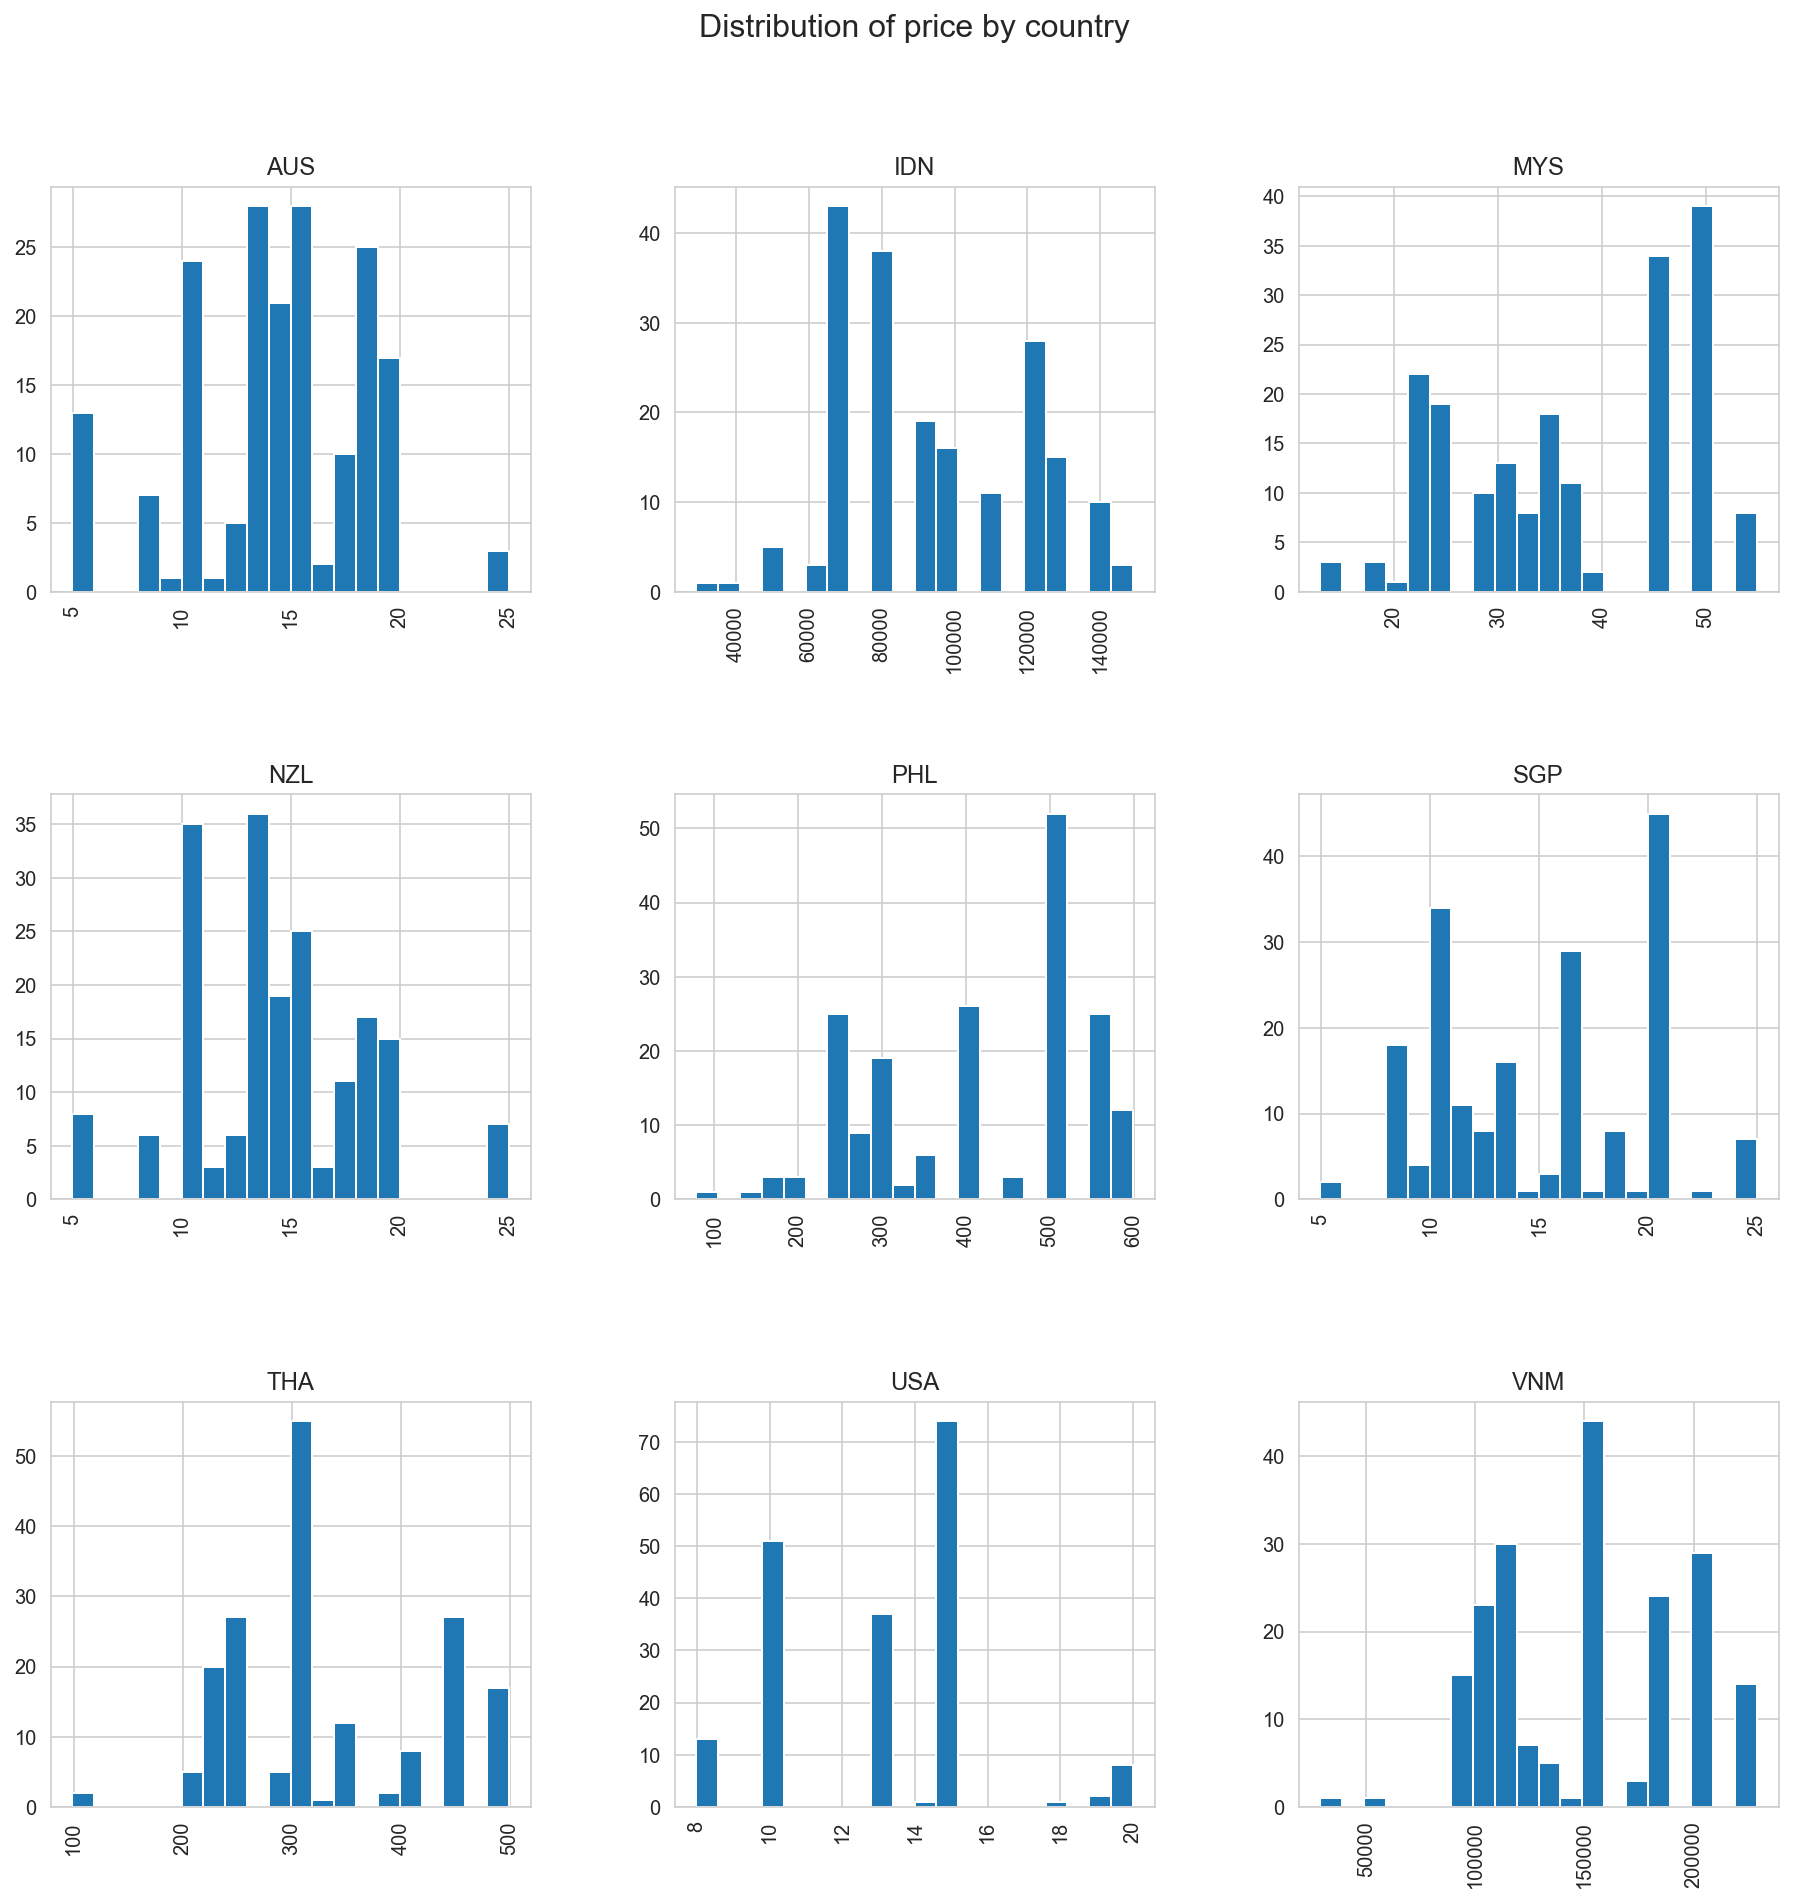

In [11]:
# Price by country relationship # 

f, ax = plt.subplots(1,1,figsize=(15,15))

itunes['main_price'].hist(by=itunes['country'],figsize=(15,15),bins=20,ax=ax)
f.suptitle('Distribution of price by country',fontsize=16)
plt.show()


<div class="alert alert-block alert-info">
<b> Observations </b>
<p>

There's no common pricing pattern across different markets that can be observed visually here. For the US for instance, there seems to be clear categories of prices at around the \$8, \$10, \$12-14 and the \$20 mark. For Indonesia, there doesn't seem to be clear cut categories of prices.
</p>
</div>

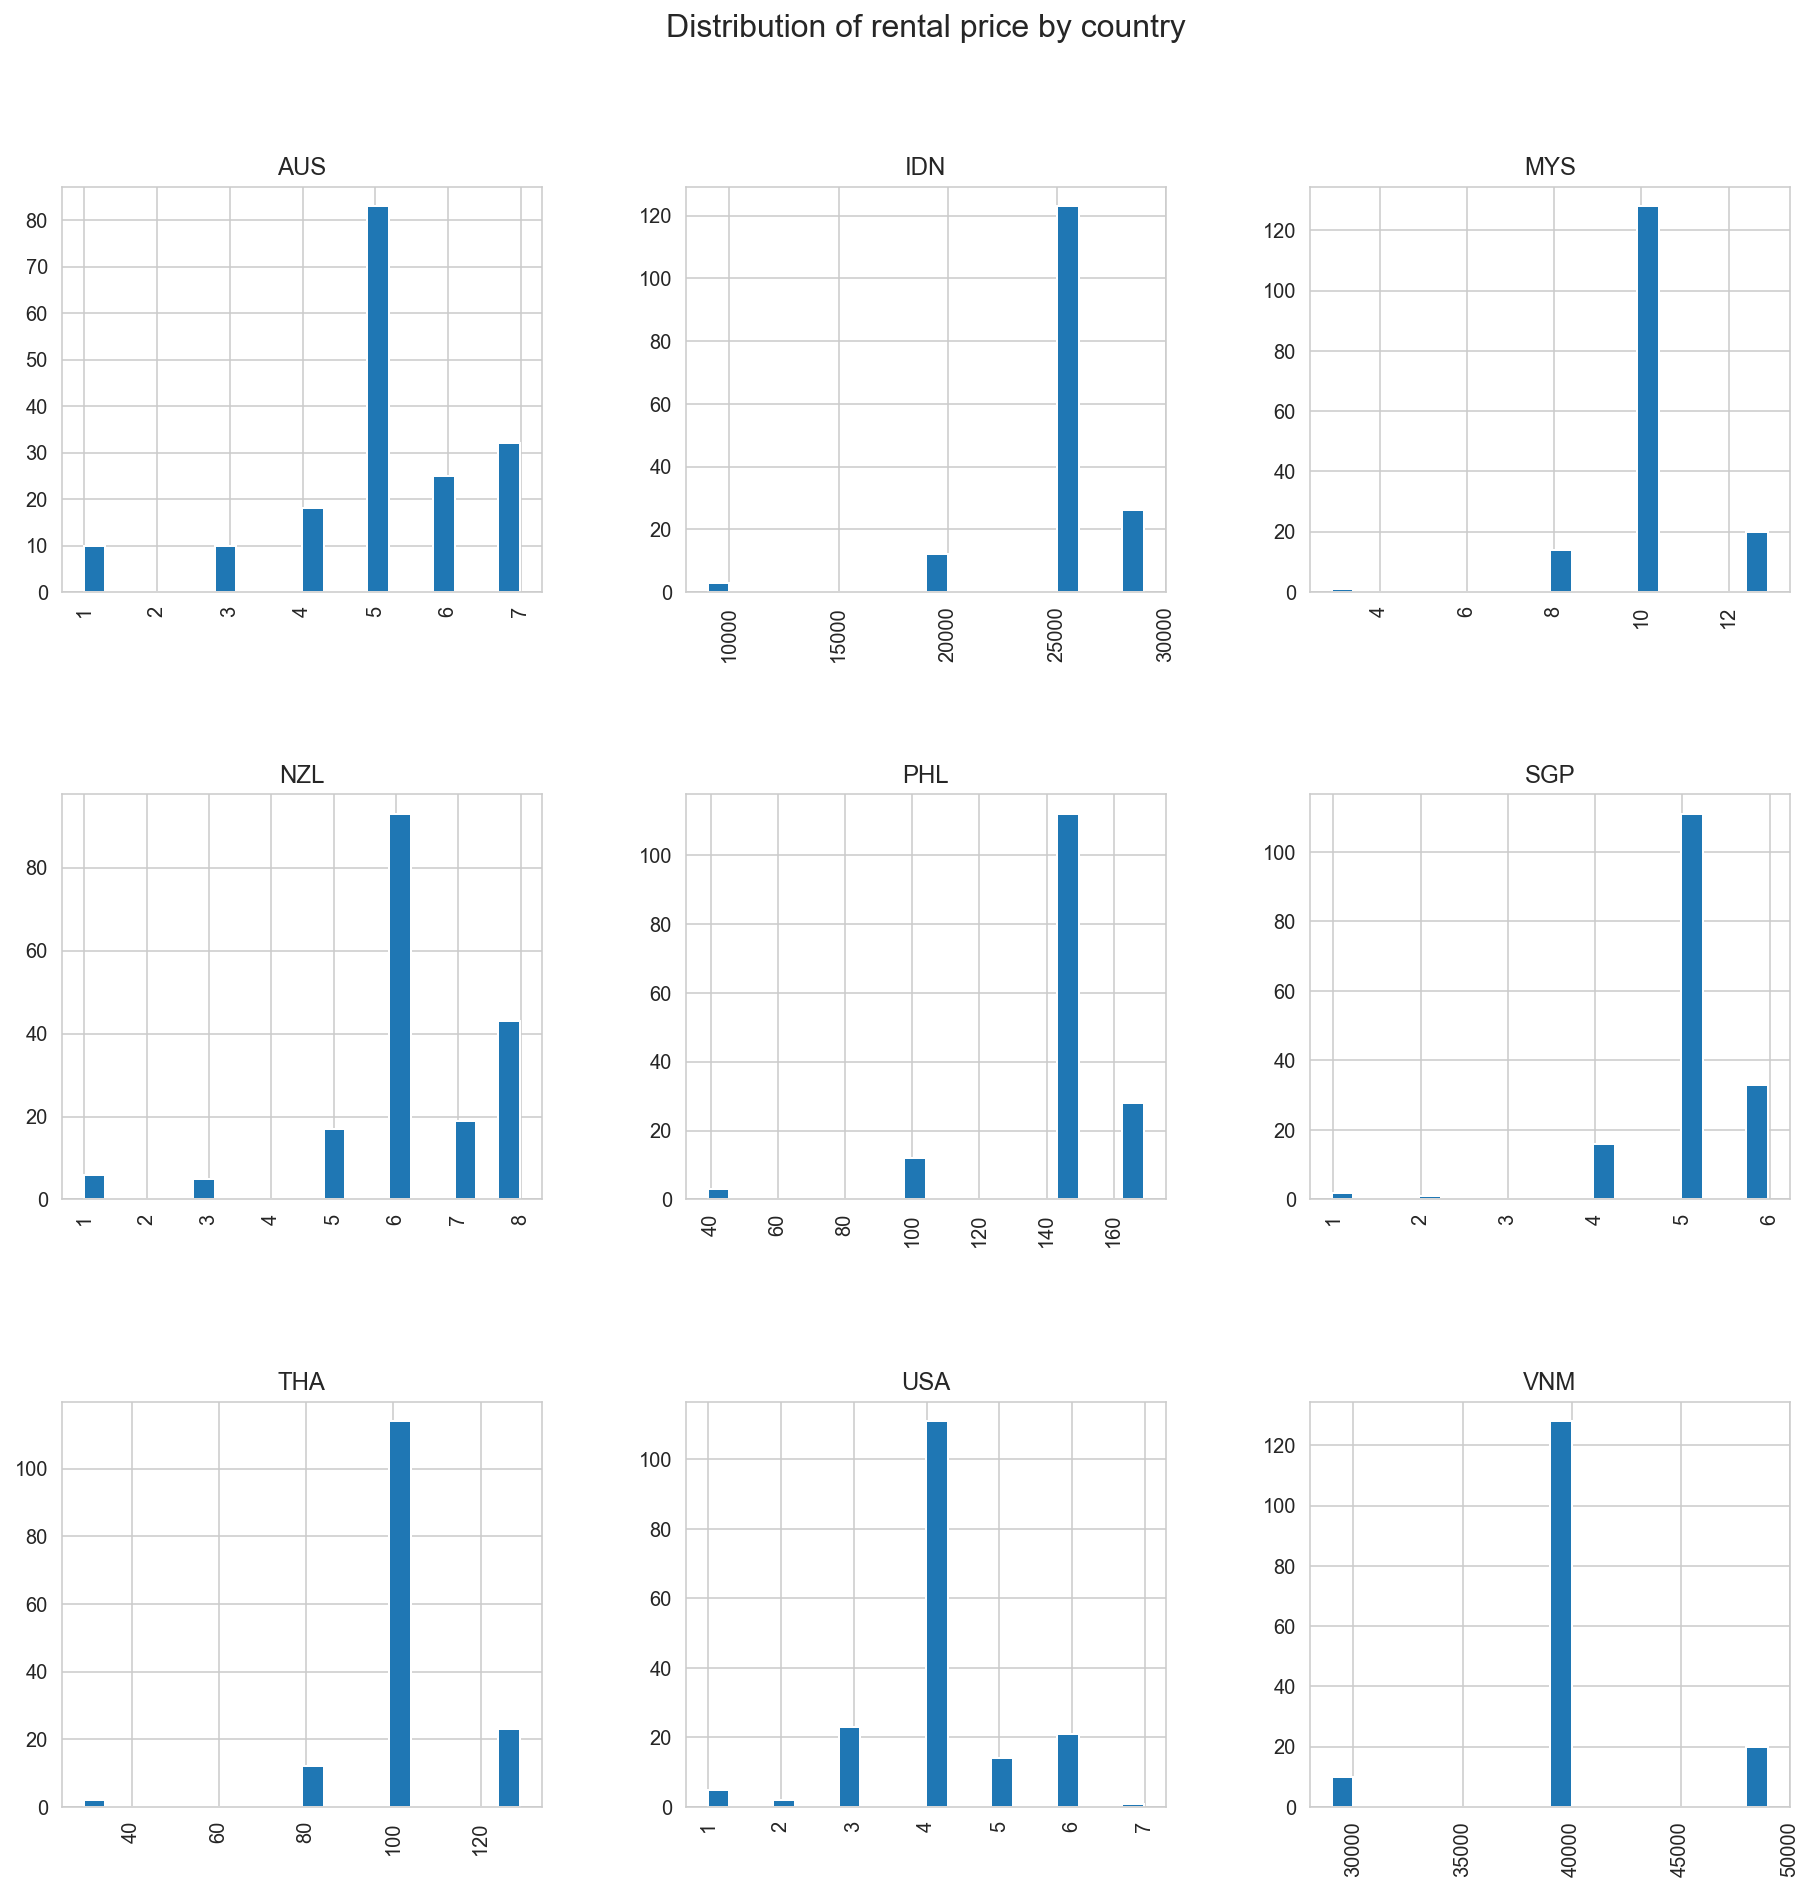

In [12]:
# Rental Price by Country # 

f, ax = plt.subplots(1,1,figsize=(15,15))

itunes['rental_price'].hist(by=itunes['country'],figsize=(15,15),bins=20,ax=ax)
f.suptitle('Distribution of rental price by country',fontsize=16)
plt.show()


<div class="alert alert-block alert-info">
<b> Observations </b>
<p>

There are more distinct categories in the rental market, ostensibly as price range for rental is more narrow, and easier to delineate. For further analysis by price, I'll consider converting them to a base currency - USD
</p>
</div>

## 3.2 Feature engineering - currency conversion ##

If I want to view more price vs other variable dynamics, I'd have to get them to the same scale. I've decided to convert them to the same base currency, USD using a currency converter.

In [13]:
## Convert to base currency using dictionary to map## 

# Define keys as currency # 
rate_keys=sorted(set(itunes['currency']))

# Using currency converter API to convert # 
try:
    url ='http://free.currencyconverterapi.com/api/v5/convert?q=%s_USD&compact=y'
    rates=[rq.get(url%a).json()['%s_USD'%a]['val'] for a in rate_keys]
# Otherwise, just use a static currency converter # 
except:
    rates=[0.718727, 6.8913238e-05, 0.239573, 0.685989, 0.018858, 0.729315, 0.030523, 1, 4.2883486e-05]


# Set up a dictionary so we can map to USD # 
rate_conv=dict(zip(rate_keys,rates))
print(rate_conv)

{'AUD': 0.71564, 'IDR': 7.0558933e-05, 'MYR': 0.243013, 'NZD': 0.675722, 'PHP': 0.019073, 'SGD': 0.73665, 'THB': 0.031201, 'USD': 1, 'VND': 4.3069104e-05}


In [14]:
# Converting price features to USD # 

itunes['rate_to_USD']=itunes['currency'].map(rate_conv)
itunes['main_price_USD']= itunes['main_price']*itunes['rate_to_USD']
itunes['rental_price_USD']=itunes['rental_price']*itunes['rate_to_USD']
itunes['hd_main_price_USD']= itunes['hd_main_price']*itunes['rate_to_USD']
itunes['hd_rental_price_USD']=itunes['hd_rental_price']*itunes['rate_to_USD']

In [15]:
genre_counts= dict(itunes['genre'].value_counts())


## 3.3 Examining relationship between price and genre of movie ## 

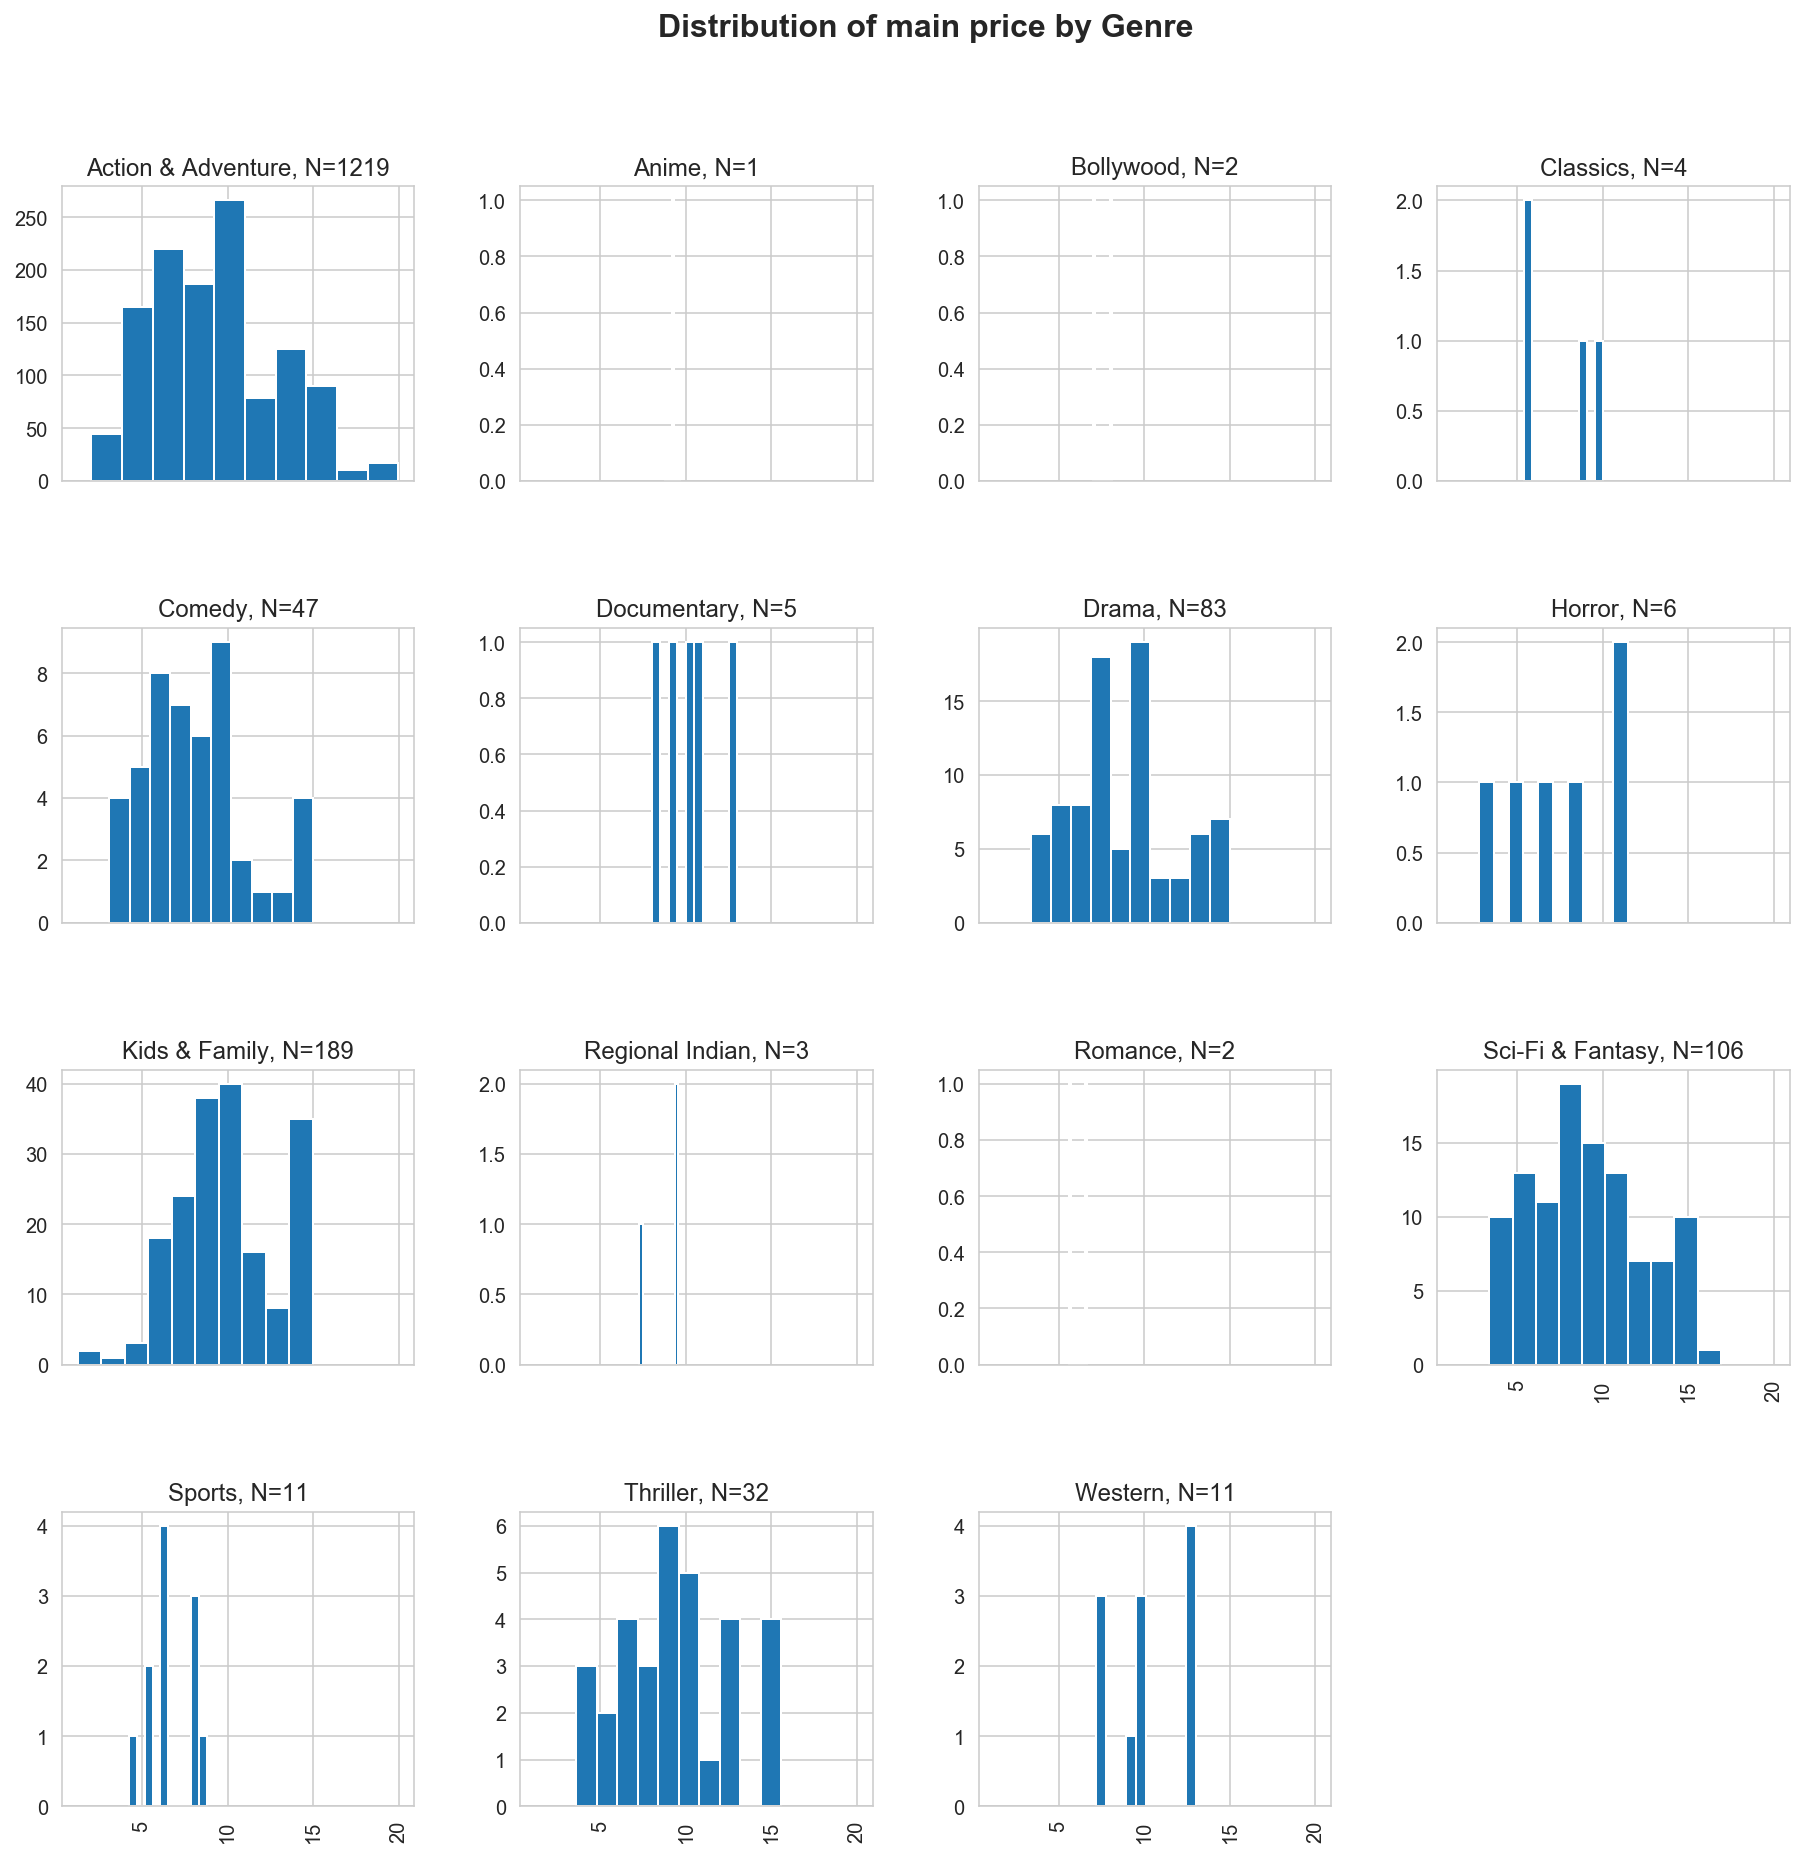

In [16]:
# Distribution plot of main price by genre # 
f, ax = plt.subplots(1,1,figsize=(15,15))

ax1=itunes['main_price_USD'].hist(by=itunes['genre'],figsize=(15,15),ax=ax,sharex=True)
f.suptitle('Distribution of main price by Genre',fontsize=16,fontweight='bold')

## Labelling the title with sub-sample size ## 
a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16=ax1.flatten()
ax_list=[a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15]

# Generate dictionary to map genre labels to counts # 
genre_counts= dict(itunes['genre'].value_counts())

# Label each subplot # 
for a in ax_list:
    genre=a.get_title()
    a.set_title(genre+', N=%d' % genre_counts[genre])

plt.show()

<div class="alert alert-block alert-info">
<b> Observations </b>
<p>

The "Action and Adventure" Category has the most titles, followed by the "Kids and Family" and "Sci-Fi" categories. The distribution of for the action and sci-fi categories look pretty similar with a slight right skew, while the kids category looks to have a slight left skew.
</p>
</div>

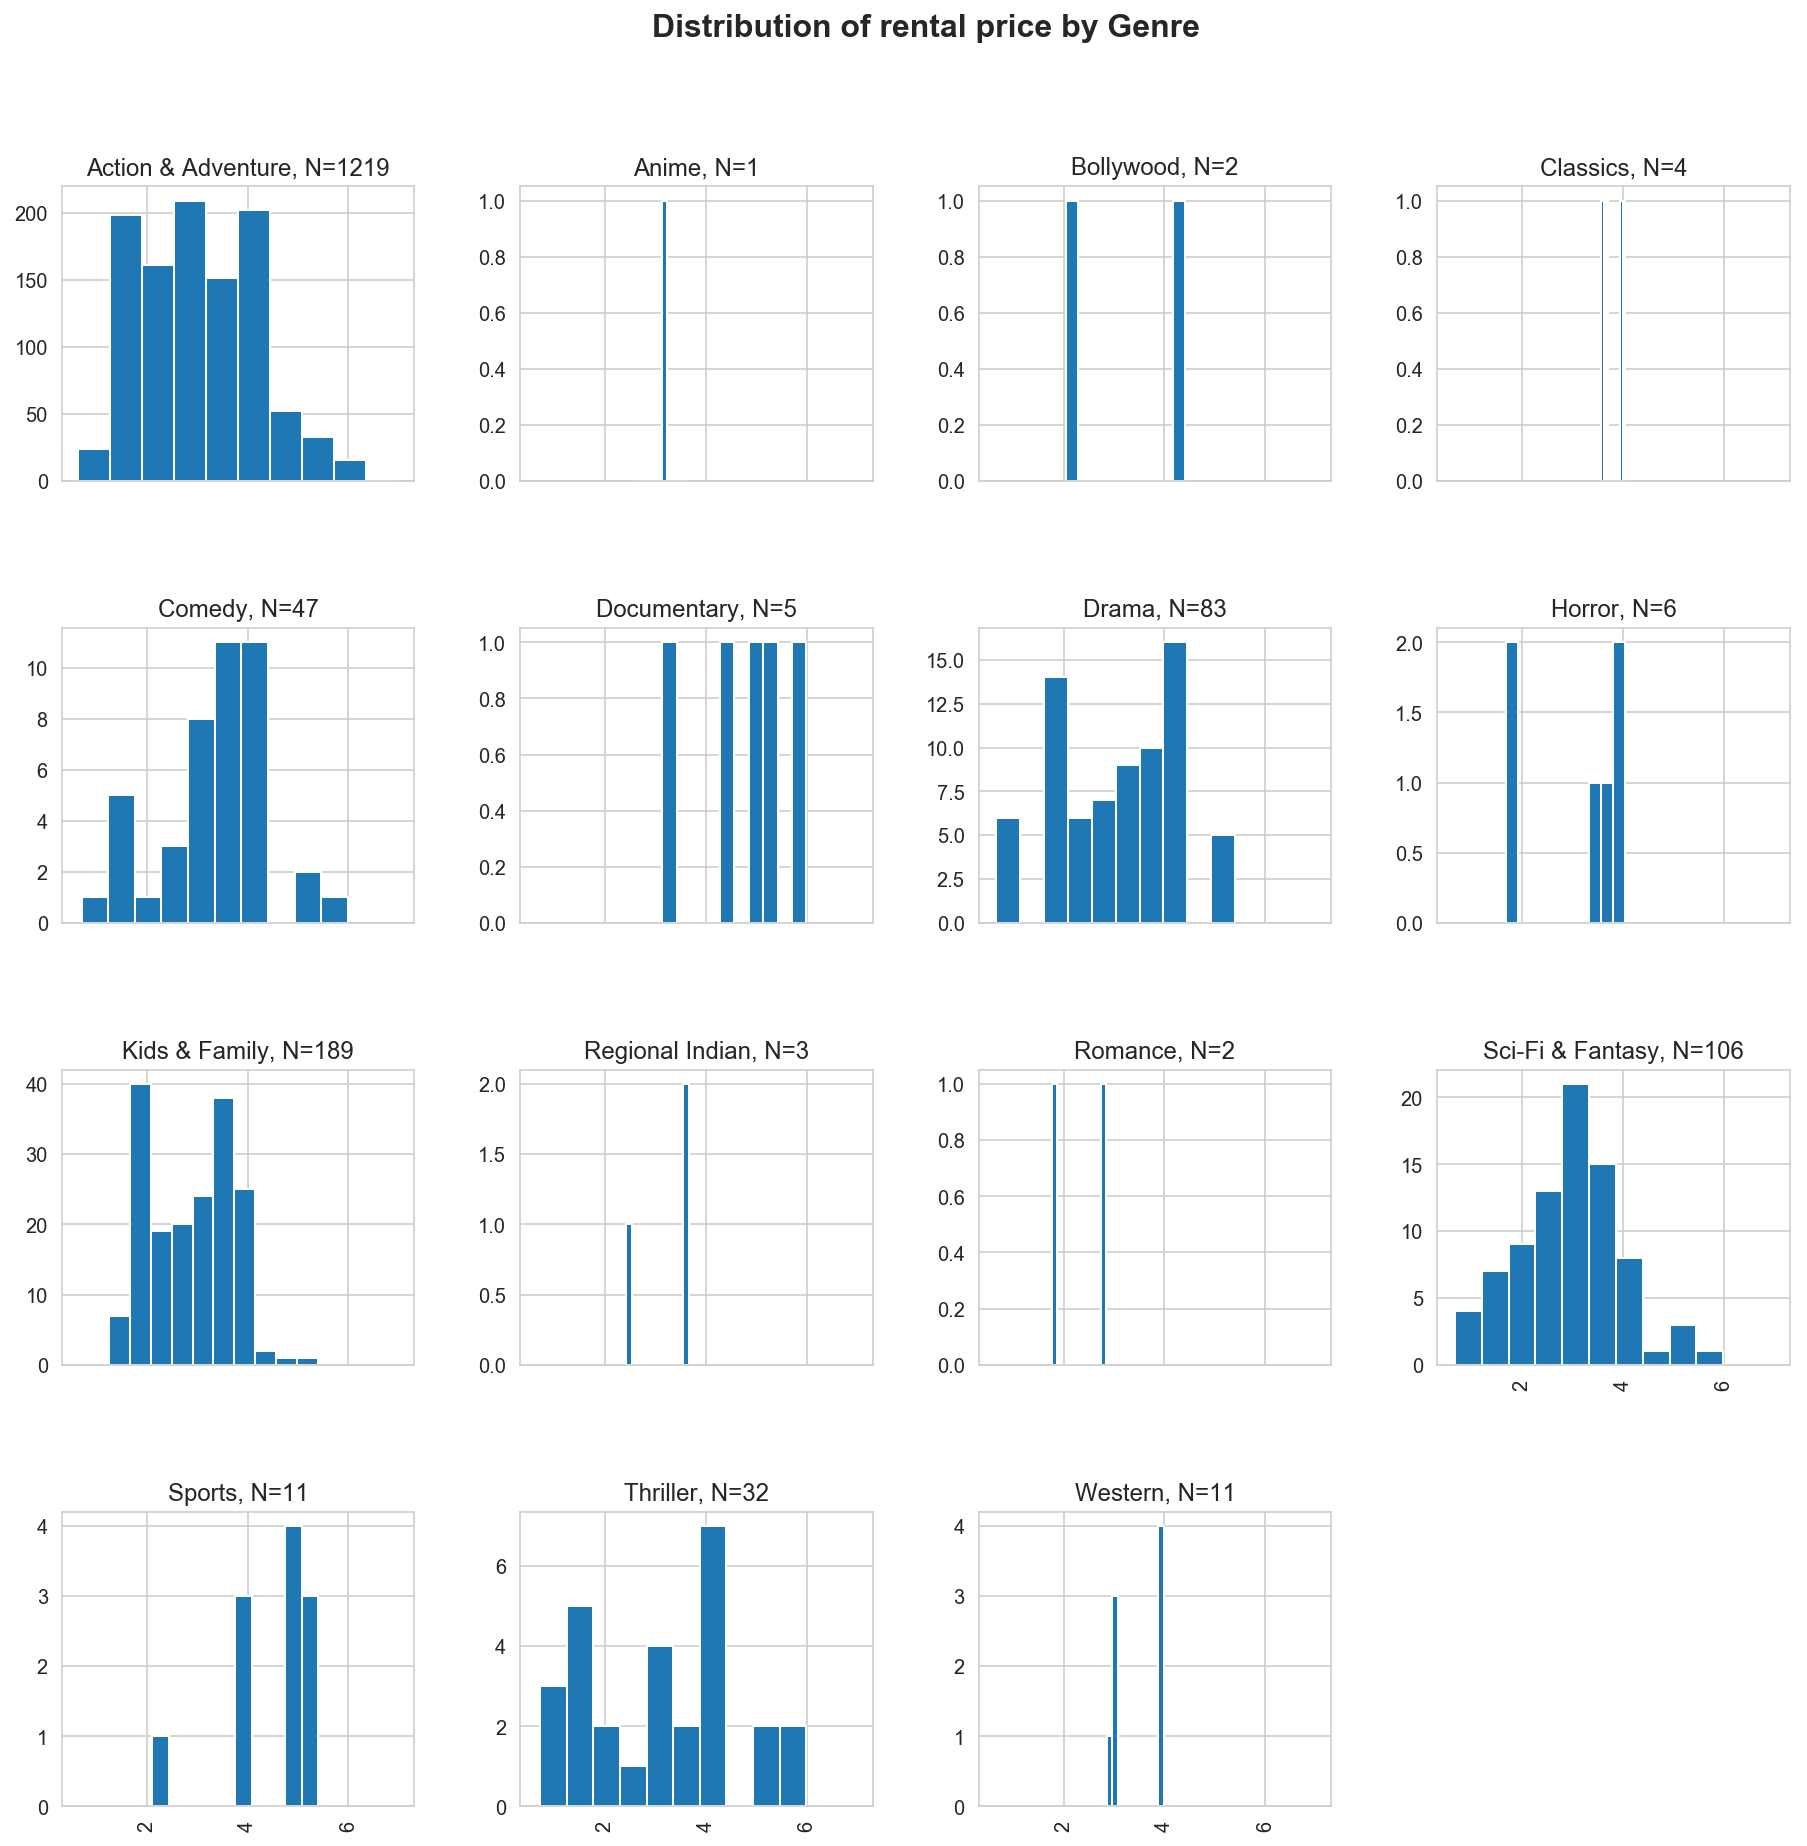

In [17]:
f, ax = plt.subplots(1,1,figsize=(15,15))

ax1=itunes['rental_price_USD'].hist(by=itunes['genre'],figsize=(15,15),ax=ax,sharex=True)
f.suptitle('Distribution of rental price by Genre',fontsize=16,fontweight='bold')

## Labelling the title with sub-sample size ## 
a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15,a16=ax1.flatten()
ax_list=[a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11,a12,a13,a14,a15]

# Generate dictionary to map genre labels to counts # 
genre_counts= dict(itunes['genre'].value_counts())

# Label each subplot # 
for a in ax_list:
    genre=a.get_title()
    a.set_title(genre+', N=%d' % genre_counts[genre])

plt.show()

<div class="alert alert-block alert-info">
<b> Observations </b>
<p>

The rental market looks a lot more symmetrical and compressed even for the popular categories, especially as the price range is lower.
</p>
</div>

## 3.4 Rental vs Purchase price, HD vs non-HD ## 

In [18]:
## Subset the data for easier processing ## 

prices_USD=itunes[['main_price_USD','rental_price_USD','hd_main_price_USD','hd_rental_price_USD']]

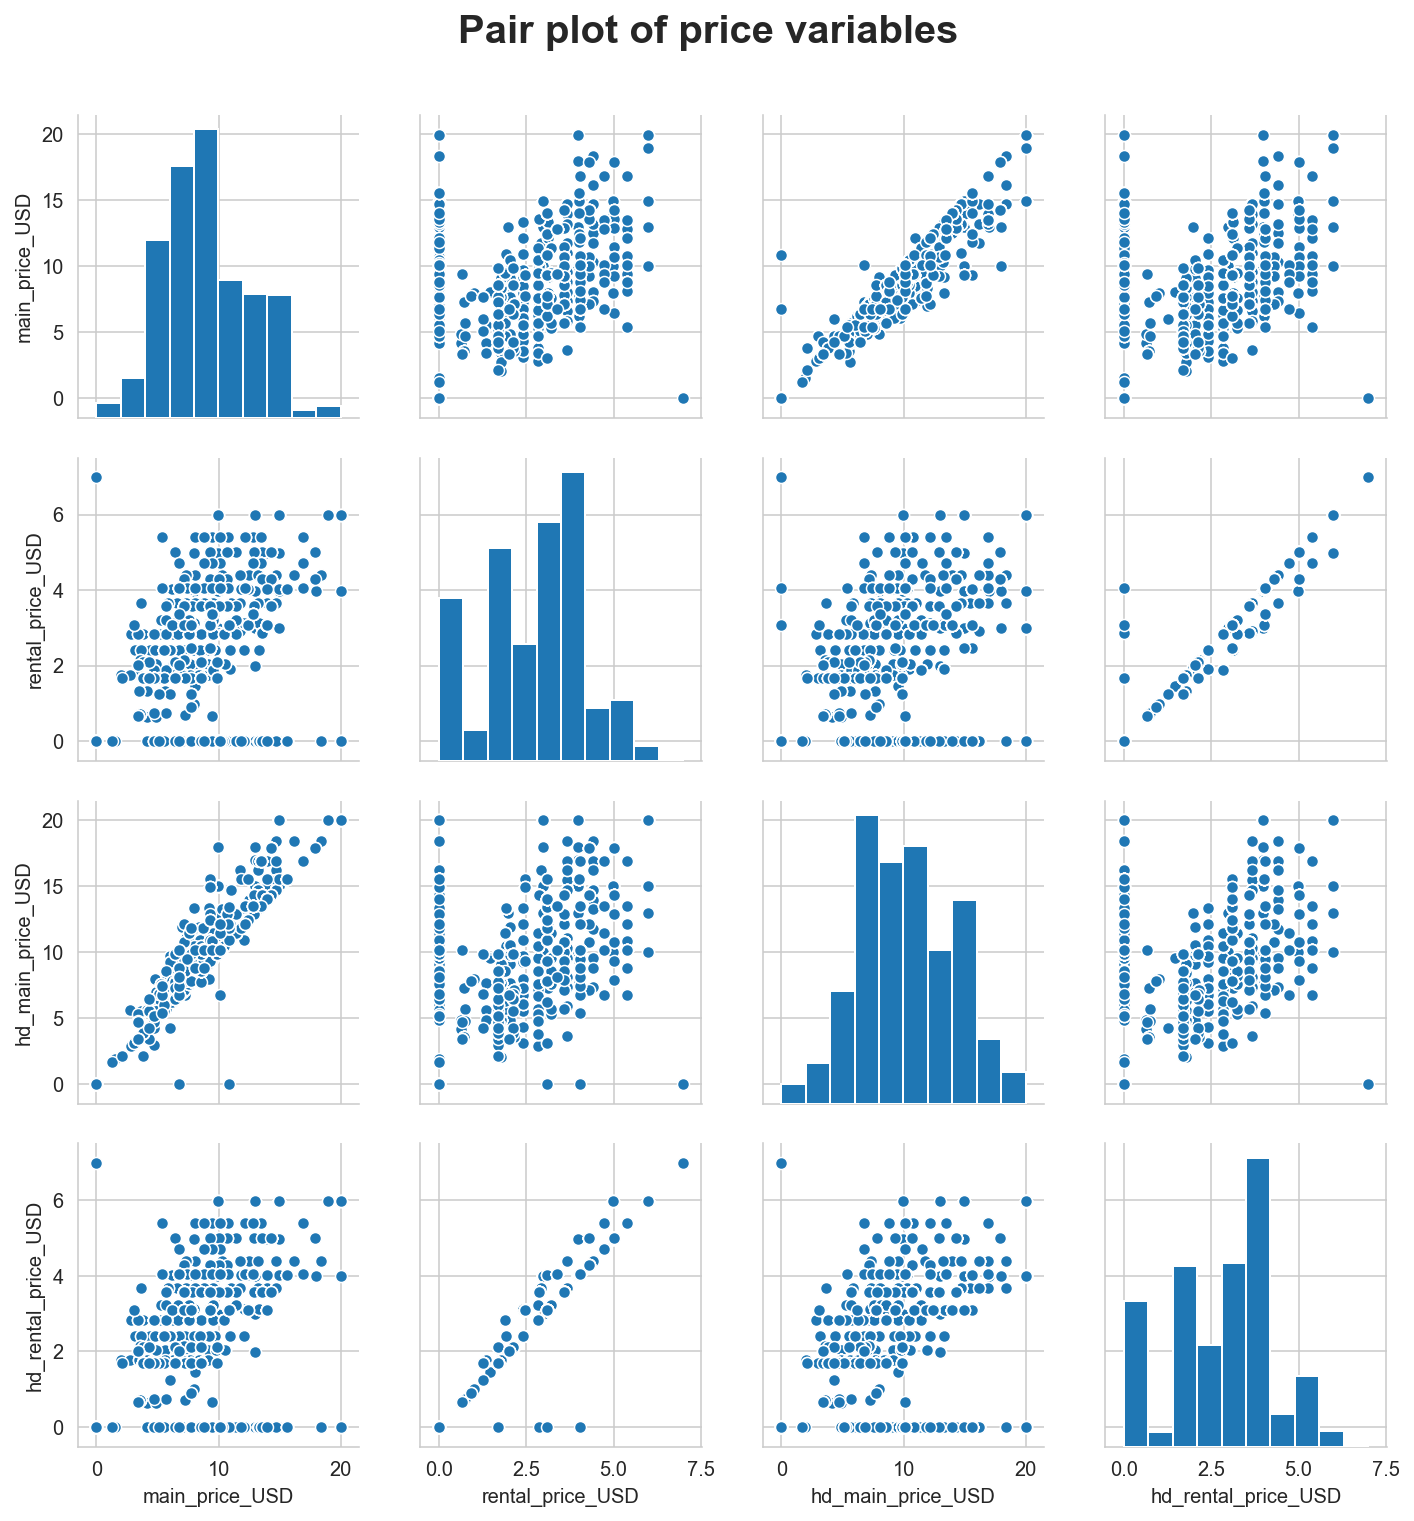

In [19]:
## Pairplot to view pair-wise relationship for prices ##
f=sns.pairplot(prices_USD.fillna(0))
f.fig.suptitle('Pair plot of price variables',fontsize=20,fontweight='bold',x=0.5,y=1.05)

plt.show()

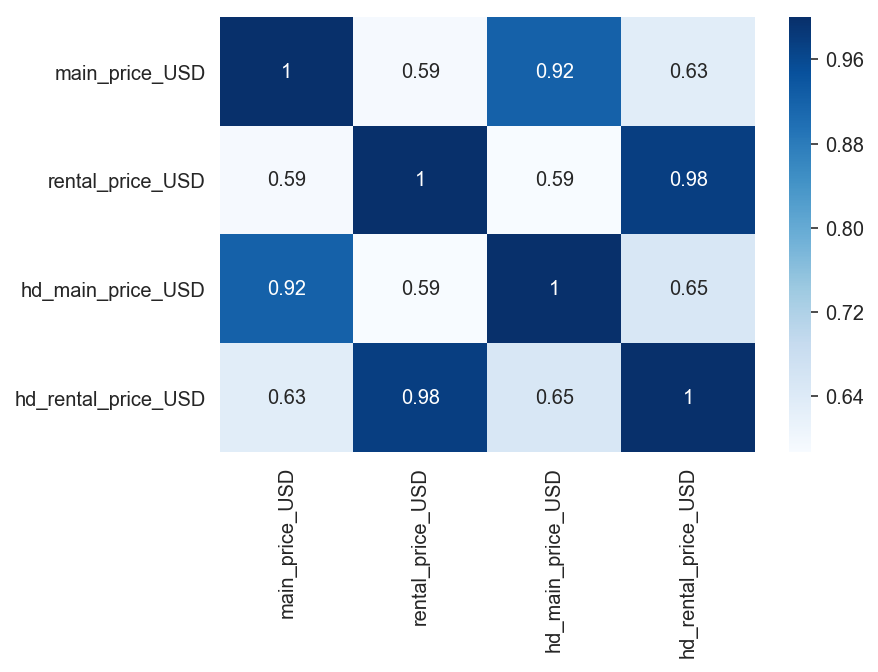

In [20]:
sns.heatmap(prices_USD.corr(),cmap="Blues",annot=True)

<div class="alert alert-block alert-info">
<b> Observations </b>
<p>

From the pairplot and correlation matrix, it's clear that HD vs non-HD relationship are highly positively (almost deterministically) correlated. Rental price and purchase price have a generally positive correlation, but to a smaller extent. 
</p>
</div>

## 3.5 Price vs Time ## 

Time is a possible predictor of price as intuitively, older titles should be priced lower because they're more available, and more people have seen it. Let's examine this further.

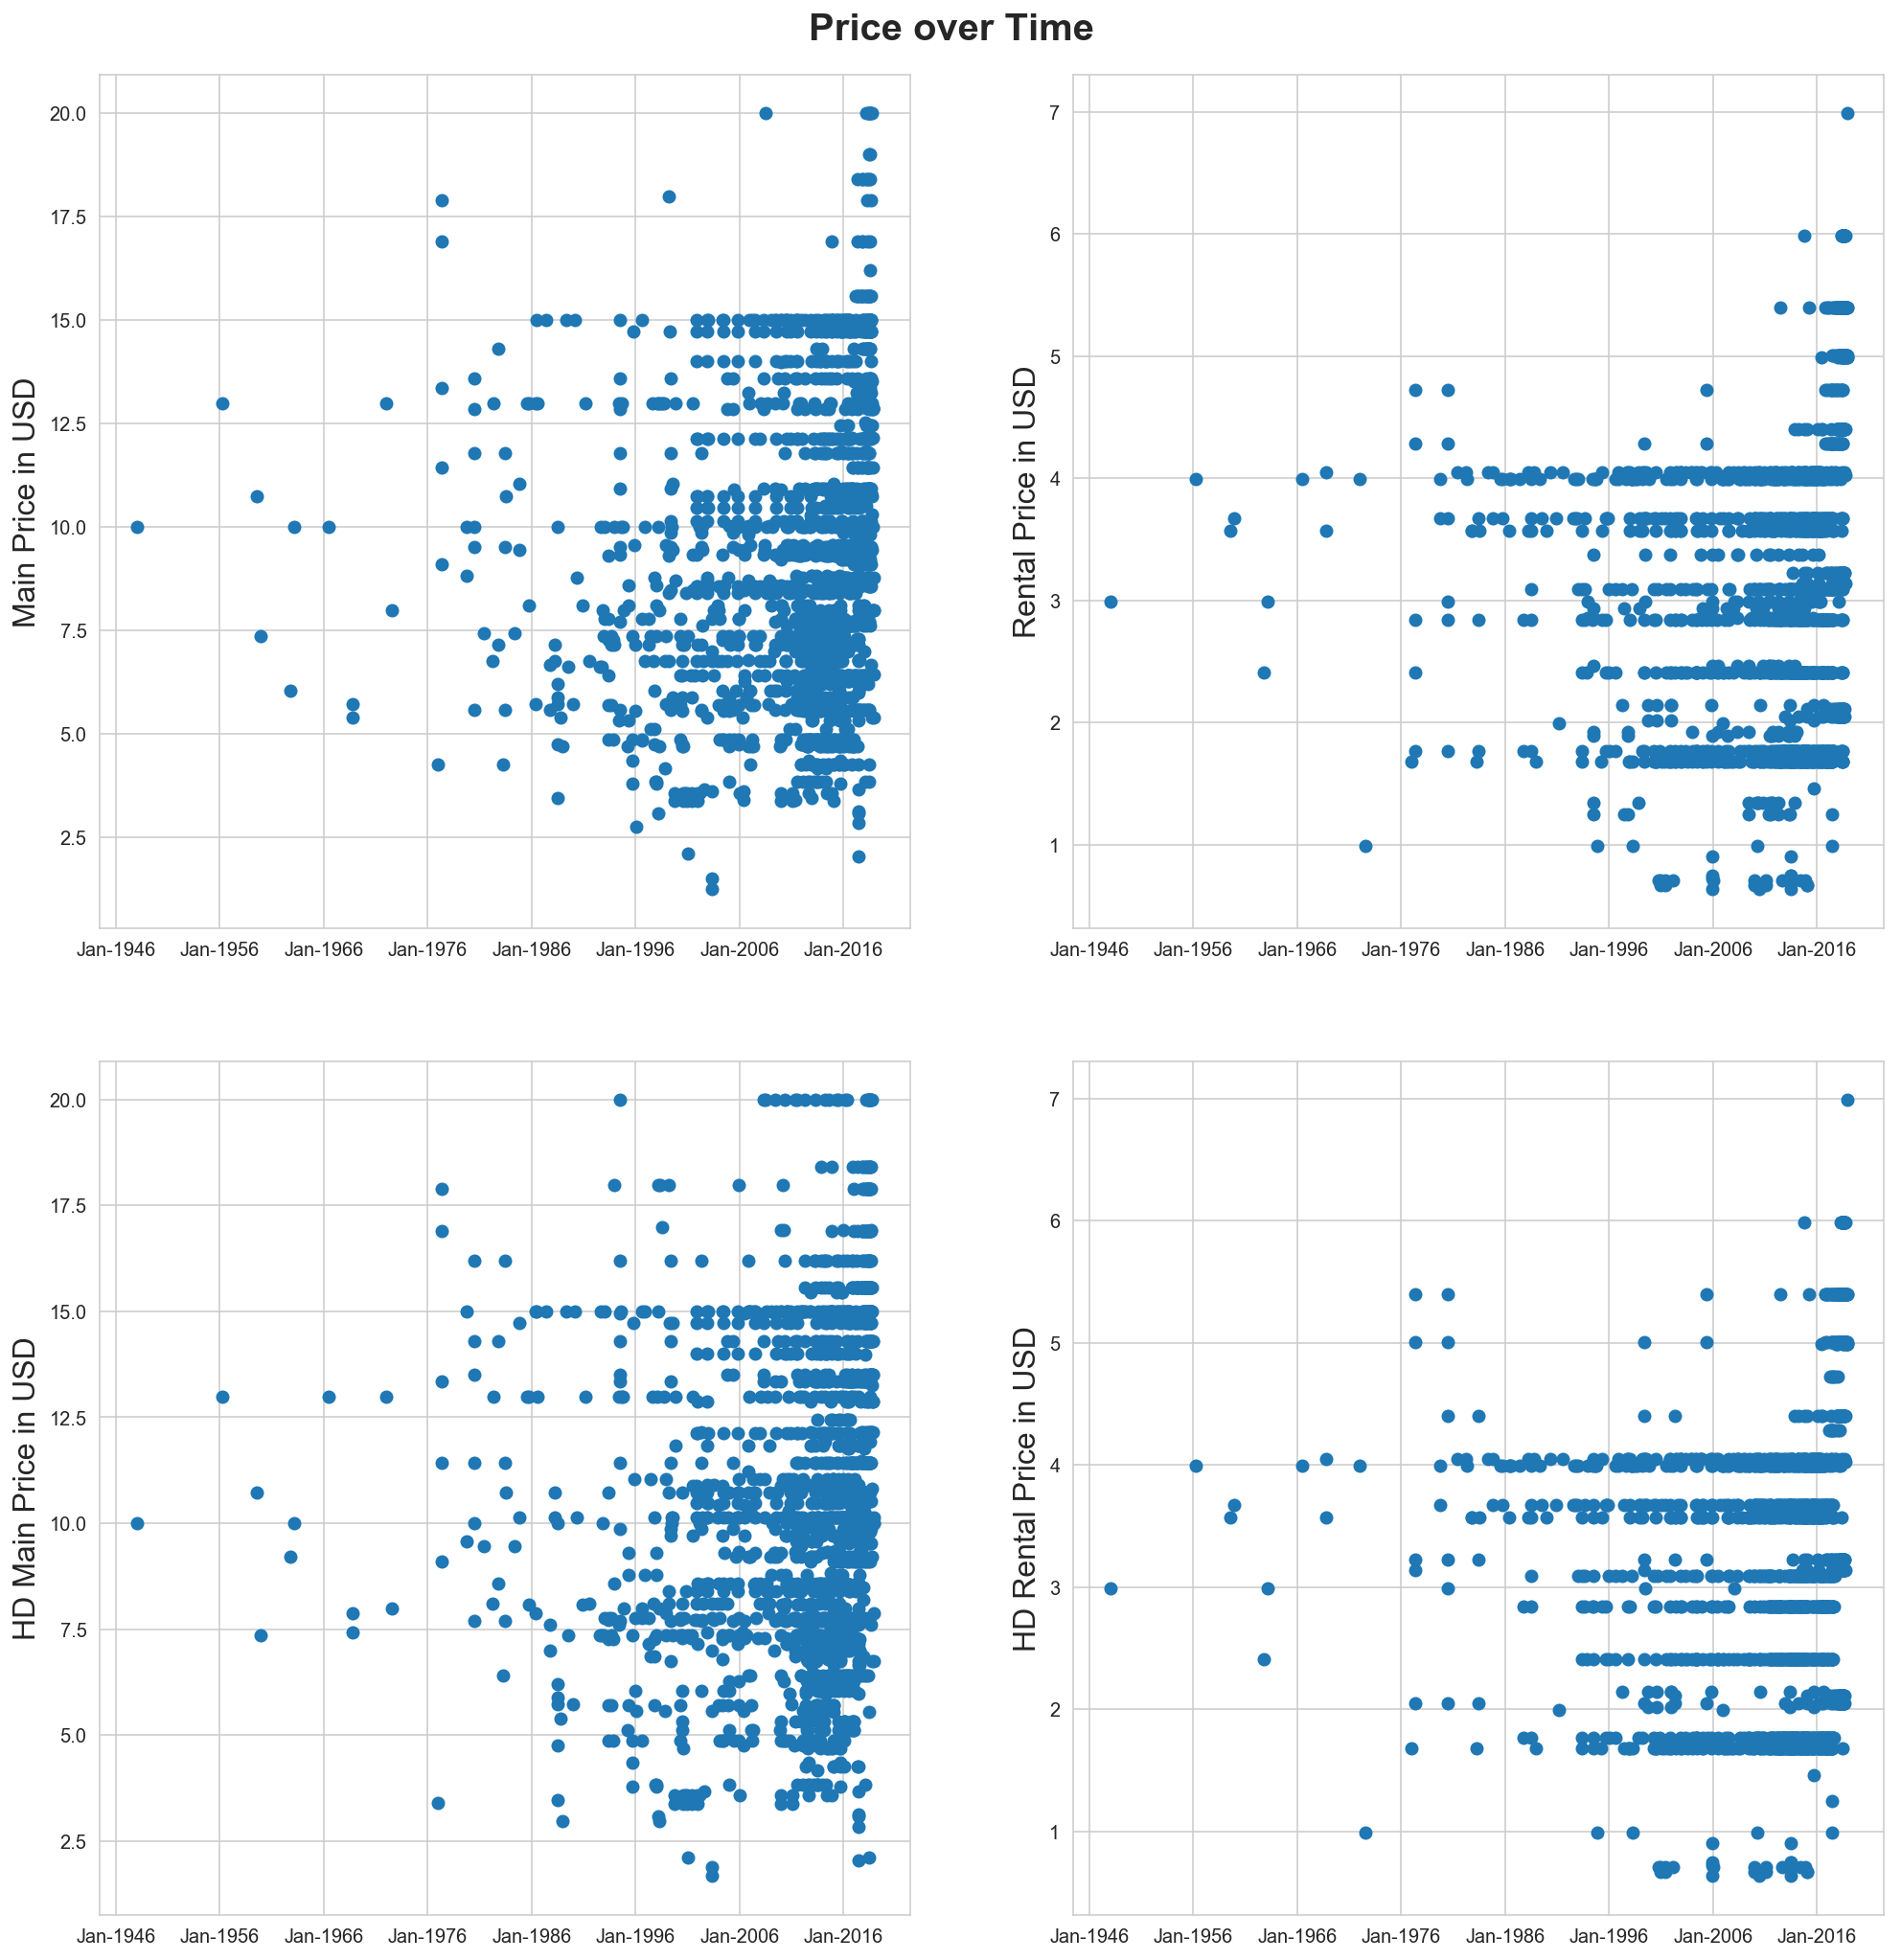

In [21]:
## Plot price vs date ## 
f, ax=plt.subplots(2,2,figsize=(15,15))

# Main Purchase Price # 
ax[0,0].plot_date(itunes['releaseDate'],itunes['main_price_USD'])
mdates.DateFormatter("%Y-%m-%dT%H:%M:%SZ")

# Use data formatter to label x axis as month-year # 
myFmt = mdates.DateFormatter('%b-%Y')
ax[0,0].xaxis.set_major_formatter(myFmt)
ax[0,0].set_ylabel('Main Price in USD',fontsize=16)

# Rental Price # 
ax[0,1].plot_date(itunes['releaseDate'],itunes['rental_price_USD'])
mdates.DateFormatter("%Y-%m-%dT%H:%M:%SZ")
myFmt = mdates.DateFormatter('%b-%Y')
ax[0,1].xaxis.set_major_formatter(myFmt)
ax[0,1].set_ylabel('Rental Price in USD',fontsize=16)

# HD Purchase Price # 
ax[1,0].plot_date(itunes['releaseDate'],itunes['hd_main_price_USD'])
mdates.DateFormatter("%Y-%m-%dT%H:%M:%SZ")
myFmt = mdates.DateFormatter('%b-%Y')
ax[1,0].xaxis.set_major_formatter(myFmt)
ax[1,0].set_ylabel('HD Main Price in USD',fontsize=16)

# HD Rental Price # 
ax[1,1].plot_date(itunes['releaseDate'],itunes['hd_rental_price_USD'])
mdates.DateFormatter("%Y-%m-%dT%H:%M:%SZ")
myFmt = mdates.DateFormatter('%b-%Y')
ax[1,1].xaxis.set_major_formatter(myFmt)
ax[1,1].set_ylabel('HD Rental Price in USD',fontsize=16)

# Set title # 
f.suptitle('Price over Time',fontsize=20,fontweight='bold')
f.tight_layout(pad=5)


<div class="alert alert-block alert-info">
<b> Observations </b>
<p>

Looking at the plots, there seems to be a (barely) discernable relationship between time and price in all 4 price categories. I'll have to do some feature engineering to calculate correlation, since a correlation coefficient of a date string and price will not be meaningful.
</p>
</div>

In [22]:
## Generate number of days since release ## 

itunes['relDate_DT']=itunes['releaseDate'].apply(lambda x: datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
itunes['days_from_release']=itunes['relDate_DT'].apply(lambda x: (datetime.today()-x).days)

In [23]:
## Check if days are int ## 
itunes[['releaseDate','relDate_DT','days_from_release']].head()

,releaseDate,relDate_DT,days_from_release
0,2018-09-14T07:00:00Z,2018-09-14 07:00:00,117
1,2018-07-27T07:00:00Z,2018-07-27 07:00:00,166
2,2018-08-10T07:00:00Z,2018-08-10 07:00:00,152
3,2018-08-17T07:00:00Z,2018-08-17 07:00:00,145
4,2018-06-15T07:00:00Z,2018-06-15 07:00:00,208


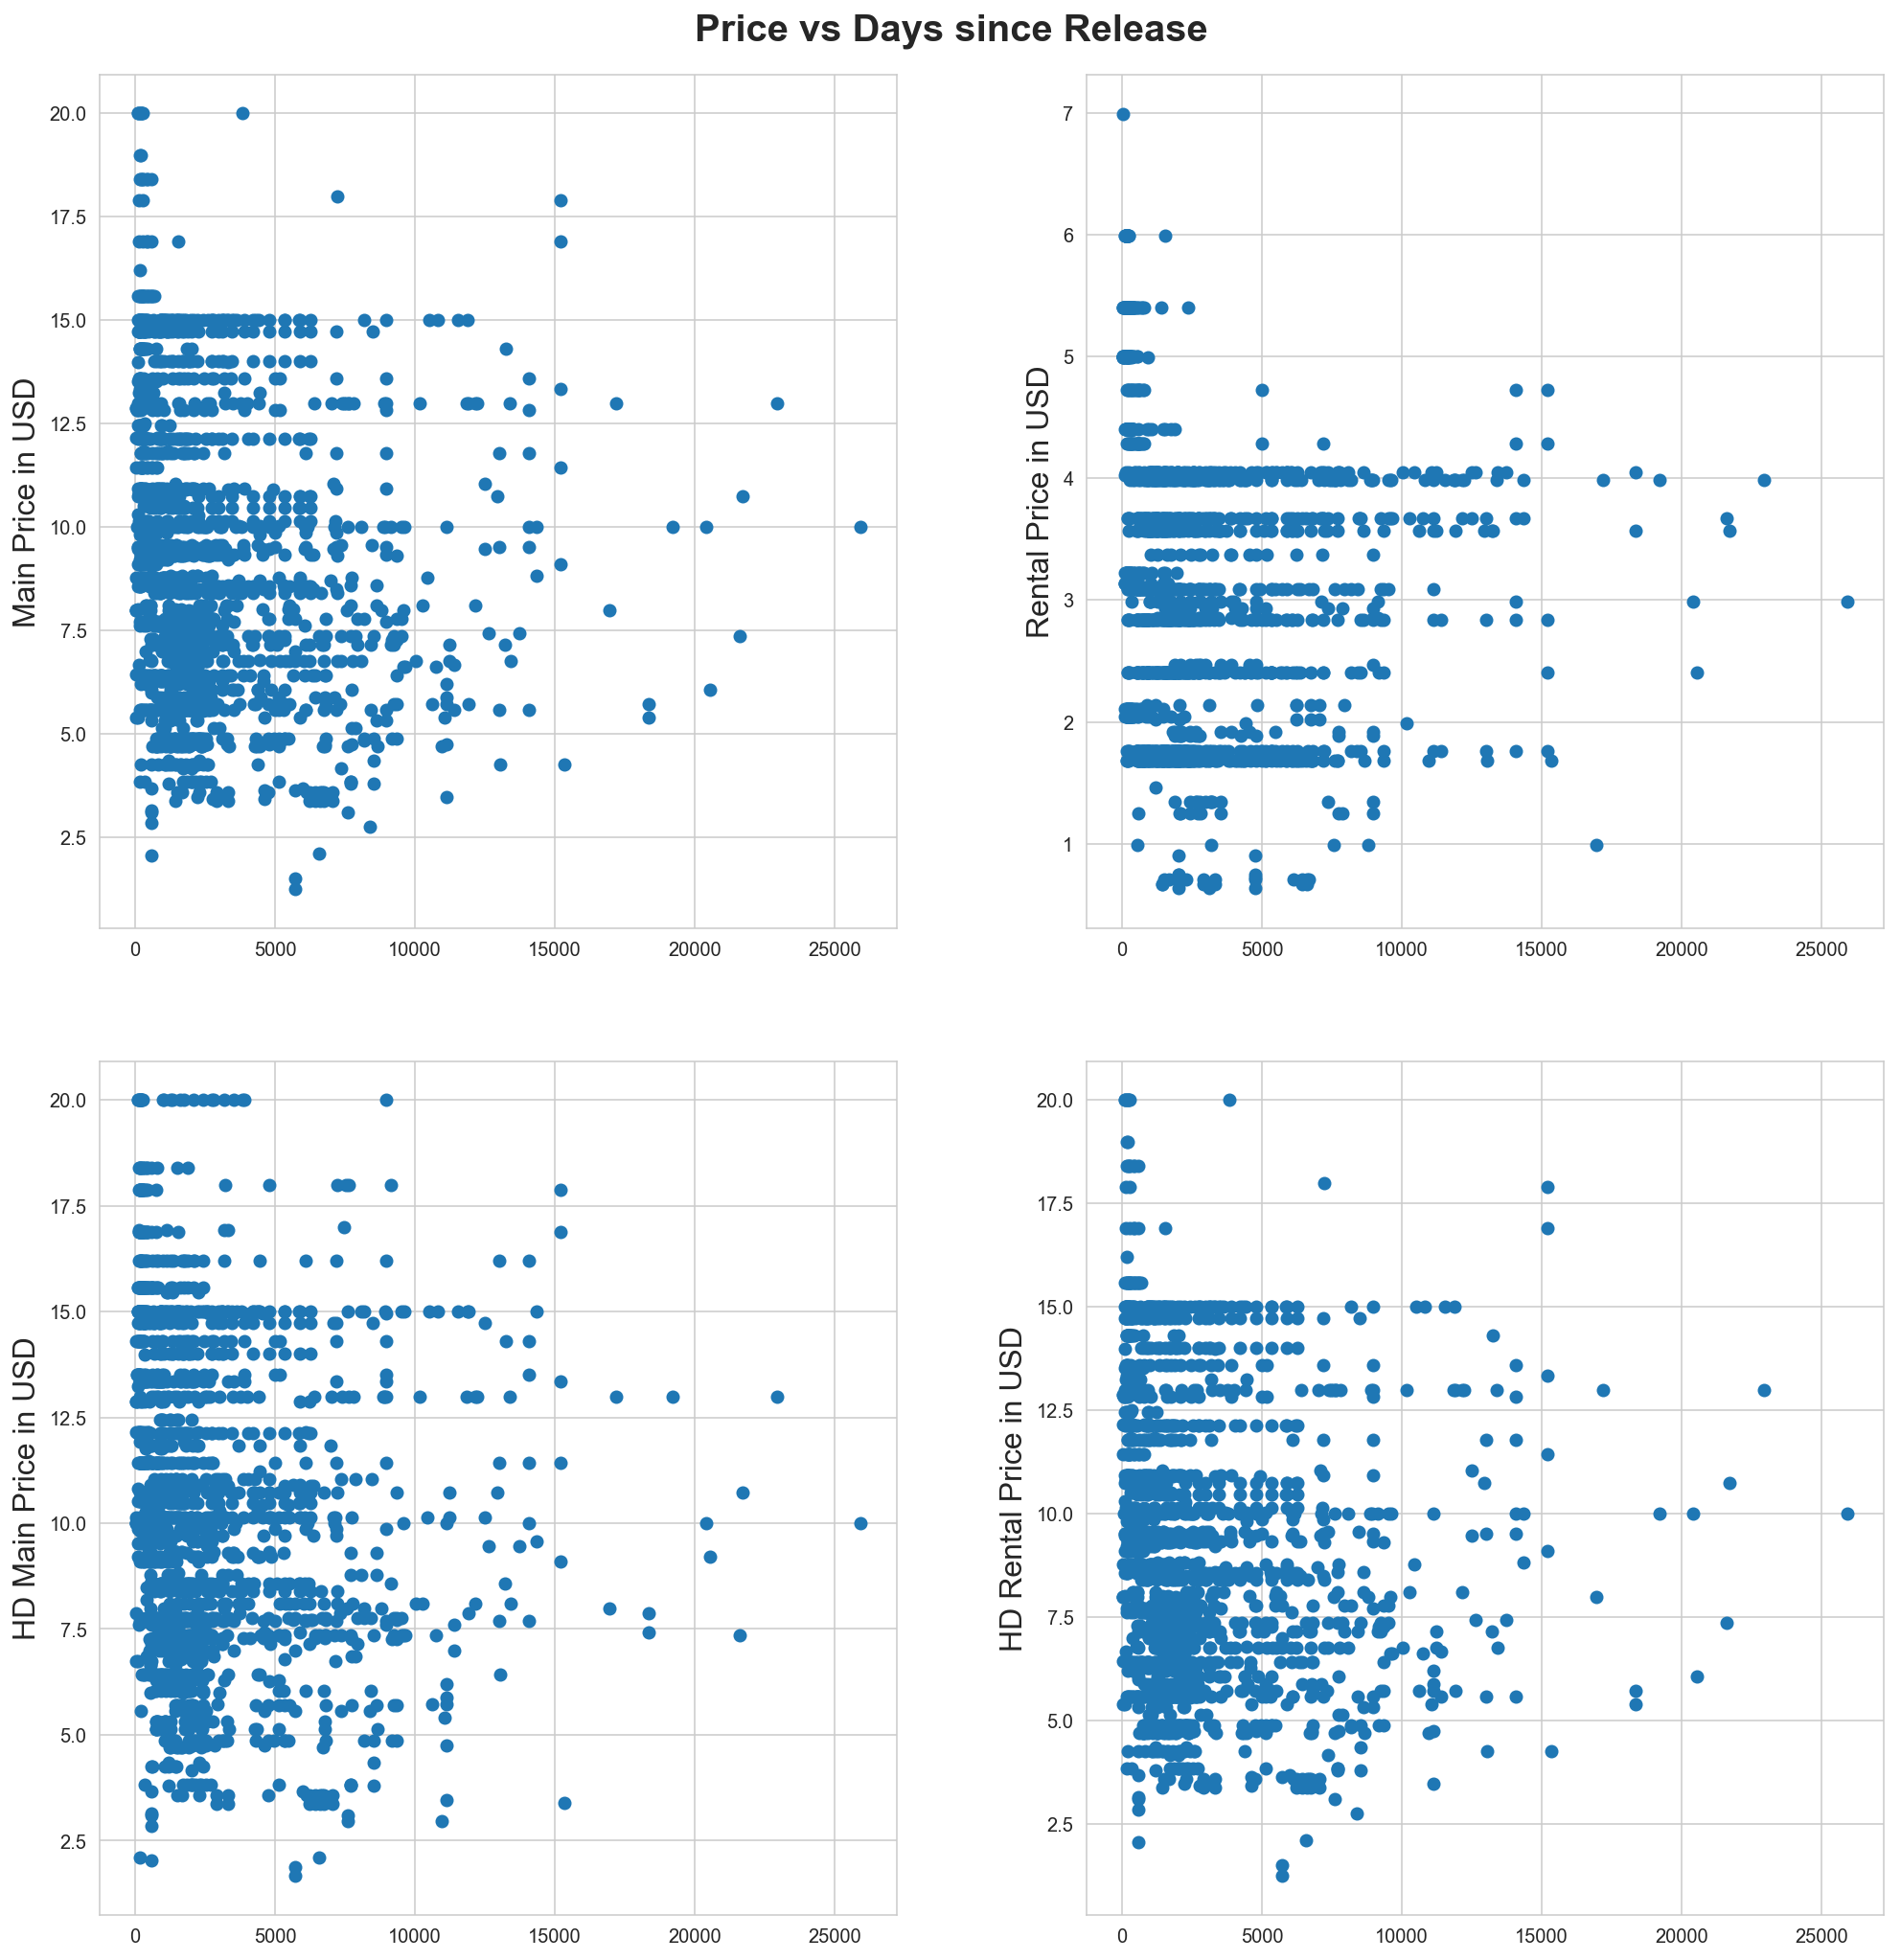

In [24]:
# Plot Price vs days since release # 

f, ax=plt.subplots(2,2,figsize=(15,15))

ax[0,0].scatter(itunes['days_from_release'],itunes['main_price_USD'])
ax[0,0].set_ylabel('Main Price in USD',fontsize=16)

ax[0,1].scatter(itunes['days_from_release'],itunes['rental_price_USD'])
ax[0,1].set_ylabel('Rental Price in USD',fontsize=16)

ax[1,0].scatter(itunes['days_from_release'],itunes['hd_main_price_USD'])
ax[1,0].set_ylabel('HD Main Price in USD',fontsize=16)

ax[1,1].scatter(itunes['days_from_release'],itunes['main_price_USD'])
ax[1,1].set_ylabel('HD Rental Price in USD',fontsize=16)

f.suptitle('Price vs Days since Release',fontsize=20,fontweight='bold')
f.tight_layout(pad=5)

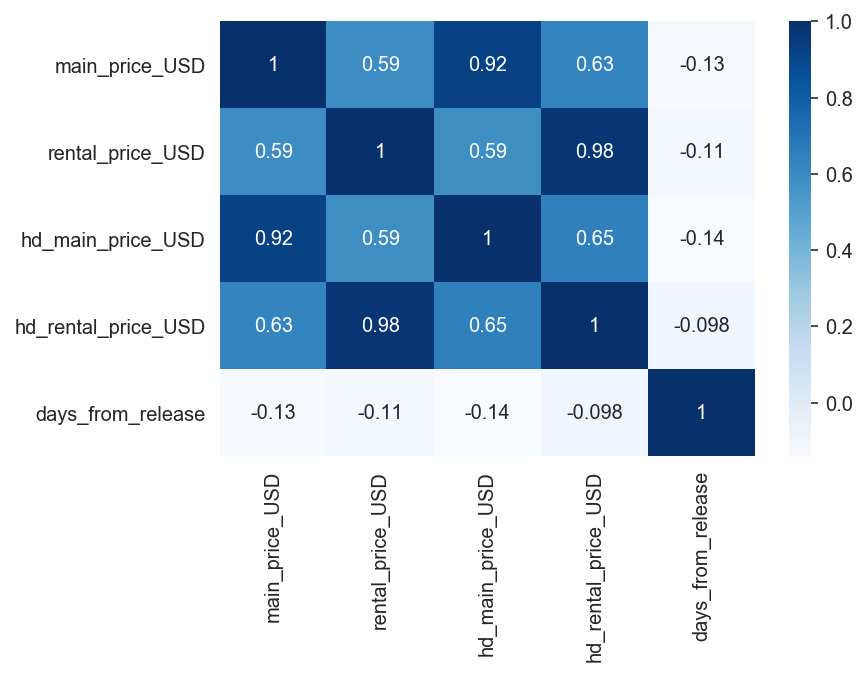

In [25]:
# See the direction of correlation between days since release vs price # 
prices_time=itunes[['main_price_USD','rental_price_USD','hd_main_price_USD','hd_rental_price_USD','days_from_release']]
sns.heatmap(prices_time.corr(),cmap="Blues",annot=True)
plt.show()

<div class="alert alert-block alert-info">
<b> Observations </b>
<p>

There seems to be slight negative correlation between time and price, with most rho values hovering around the -0.1 range. I'll check their p-values next to see if rho is significant. I'll also take a look at spearman's for a more robust check - there are some big values that might skew the distribution slightly. 
</p>
</div>

In [26]:
## Test at 5% significance level whether rho=0 ## 

rho_mat=prices_time.corr(method='pearson')

n=len(itunes['main_price'])
for i in range(rho_mat.shape[1]-1):
    
    rho=prices_time.corr(method='pearson').iloc[4,i]
    
    # Rho Test Stat # 
    T=(rho*(n-2)**0.5)/((1-rho**2)**0.5)
    
    # return p value at n-2 degrees of freedom # 
    p_val=stats.t.cdf(T,df=n-2)
    
    if p_val<0.05:
        print('At alpha=5%, Pearson rho is different from 0 at for {} vs {} with p-value {:06.5f}'.format(rho_mat.index[i],rho_mat.index[4],p_val))
    else:
        print('At alpha=5%, Pearson rho is not different from 0 at for {} vs {} with p-value {:06.5f}'.format(rho_mat.index[i],rho_mat.index[4],p_val))

At alpha=5%, Pearson rho is different from 0 at for main_price_USD vs days_from_release with p-value 0.00000
At alpha=5%, Pearson rho is different from 0 at for rental_price_USD vs days_from_release with p-value 0.00000
At alpha=5%, Pearson rho is different from 0 at for hd_main_price_USD vs days_from_release with p-value 0.00000
At alpha=5%, Pearson rho is different from 0 at for hd_rental_price_USD vs days_from_release with p-value 0.00002


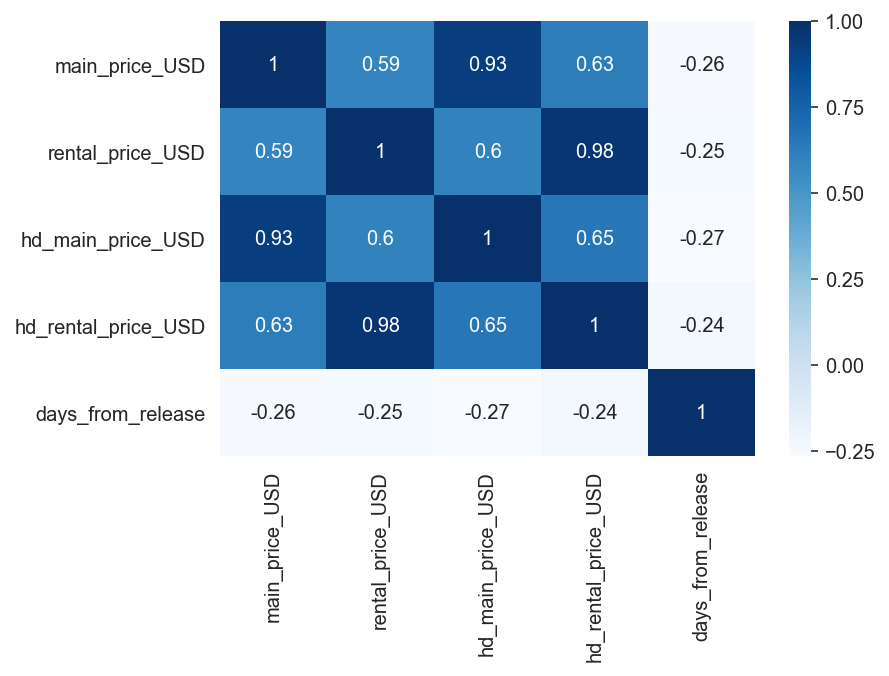

In [27]:
# Check spearman rho # 
sns.heatmap(prices_time.corr(method='spearman'),cmap="Blues",annot=True)
plt.show()

In [31]:
## Export clean data and engineered features to new csv ## 

itunes.to_csv('../data/clean/itunes_clean.csv',index=False)

<div class="alert alert-block alert-info">
<b> Observations </b>
<p>

There is a non-zero correlation between time and price across all price categories, so we can't really discount price as a predictor. I'll probably have to consider it as a feature later on in my model. Applying spearman's rho actually improved the strength of the correlation, so I gather the skew might be affecting the pearson correlation. 
</p>
</div>

# 4. Follow up tasks and questions #

It's quite apparent that I probably won't get a good prediction from this data set alone.Price is a good predictor of price, but there's no way I can know that *a priori*. 

There's so much intuition that can be captured by data which I haven't touched yet. I'll be looking at a few more datasets next to determine the quality and characteristics of a movie, as well as its performance at the box office. 

The main thing is whether I can relate these features individually to a specific movie.

I'm still in two minds about whether to apply a currency converter to bring the currency variable to a common scale. This seems like the most logical thing to do, but exchange rates **fluctuate**, which causes me a real headache. How do I know that the features I'm choosing are actually accounting for the variations caused by exchange rates? I'll probably also consider converting my price variable to an ordinal variable that is exchange-rate invariant. But then I face the problem of arbitrarily deciding how many levels should this price variable should be. 

Thoughts and comments are most welcome. 